# LP and MIP

## Test out `cvxpy` and linear programming

In [1]:
import cvxpy as cvx
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt

In [2]:
cvx.installed_solvers()

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCS']

In [3]:
n = 10
m = 5
np.random.seed(1)
A = np.random.randn(n, m)
b = np.random.randn(n)

x = cvx.Variable(m)
constraints = [
    0 <= x, x <= 1
]

obj = cvx.Minimize(cvx.sum_squares(A*x - b))

prob = cvx.Problem(obj, constraints)
prob.solve(solver=cvx.CVXOPT);

In [4]:
print("Using CVXOPT:")
print("status:", prob.status)
print("optimal objective:", prob.value)
print(f"optimal vars - x={x.value}")

Using CVXOPT:
status: optimal
optimal objective: 4.1413380197190195
optimal vars - x=[-8.48527714e-08 -5.67853902e-08  1.34636455e-01  1.24964056e-01
 -5.38616202e-08]


## Try out some MIP

We'll solve a small traveling salesman problem using integer programming. We are given a set of $N$ locations $L \in \mathbb{R}^{N\times 2}$, with a distance matrix $D \in \mathbb{R}^{N\times N}$. We have a set of boolean decision variables $X \in \mathbb{R}^{N\times N}$ where the $X_{ij}$ entry says to travel from the $i$th location to the $j$th location. We will also introduce $N$ slack variables $1 \le u_i \le N-1$ which describes the visitation order for the $i$th location ($u_0$ is fixed to zero).

We want to find the route that minimizes the total distance traveled, while still visiting all the locations, and returning back to the origin. This means we must solve the following problem:

$$
\min_X \sum_{i,j=1}^{N} D_{ij} X_{ij} \\
\text{subject to} \\
\sum_{i=1,i\neq j}^{N} X_{ij} = 1, \qquad
\sum_{j=1,j\neq i}^{N} X_{ij} = 1, \qquad
X_{ii} = 0, \\
u_0 = 0,\,1 \le u_i \le N-1;\, i \in [1, N], \qquad
u_i - u_j + NX_{ij} \le N-1;\, \forall i \neq j
$$

In [89]:
# Simple traveling salesman problem
from scipy.spatial.distance import pdist, squareform
N = 15    # number of locations
np.random.seed(1)
locations = np.random.randn(N, 2)    # (x,y) coordinates of the locations
D = squareform(pdist(locations))    # distance matrix between locations

# Location visitation variables; 
X = cvx.Variable((N, N), boolean=True)
u = cvx.Variable(N-1, integer=True)

# Constraints
constraints = [
    cvx.sum(X, axis=0) == 1,
    cvx.sum(X, axis=1) == 1,
    cvx.trace(X) == 0,
    1 <= u, u <= N-1
]
constraints.extend(
    [u[i-1] - u[j-1] + N*X[i,j] <= N-1 for i in range(1, N) for j in range(1, N) if i != j]
)

# Objective
obj = cvx.Minimize(cvx.sum(cvx.multiply(D, X)))

# Problem
prob = cvx.Problem(obj, constraints)
%time prob.solve(solver=cvx.GLPK_MI, glpk={"tmlim": 1, "presolve": "GLP_ON"})

CPU times: user 2.1 s, sys: 0 ns, total: 2.1 s
Wall time: 2.1 s


11.759253652968988

In [90]:
print("Problem status:", prob.status)
print("Location index:", np.arange(N))
print("argmax(X):     ", np.argmax(X.value, axis=1))
print("Visitation order:", [0]+u.value.astype(int).tolist()+[0])

Problem status: optimal
Location index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
argmax(X):      [ 3 13  1  7 12  2 10  5  6 11 14  4  0  8  9]
Visitation order: [0, 5, 4, 1, 13, 3, 8, 2, 7, 11, 9, 12, 14, 6, 10, 0]


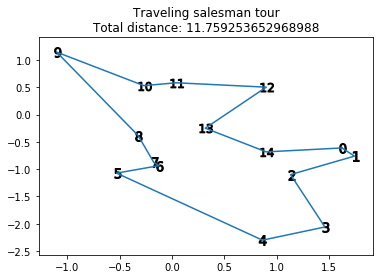

In [91]:
order = list(list(zip(*sorted(
    zip(
        list(range(N))+[0], 
        [0]+u.value.astype(int).tolist()+[N]
    ), 
    key=lambda e: e[1]
)))[0])
tour = locations[order]
plt.plot(*tour.T)
for i, t in enumerate(tour[:-1]):
    plt.scatter(*t, marker=f"${i}$", color='black', s=100*len(str(i)))
plt.title(f"Traveling salesman tour\nTotal distance: {prob.value}")
plt.show()

In [88]:
cvx.__version__

'1.0.25'